# Libraries, Headers and Stuff

In [1]:
import sys
sys.path.append('../../src')

In [2]:
CACHED = True
CONTINUE = False

N_STATES = 256
N_EPOCHS =  50
BATCH_SIZE = 32

MAX_VOCAB_SIZE = -1
MAX_SEQUENCE_SIZE = -1

LAYERS_TO_CHECK = [0]

import scores
METRIC = scores.Correlation()

SAMPLES_VERIFY = 8
TEST_RATIO = .1

MODEL_NAME = '1_layer_256_cells_dropout_0.5'

In [3]:
import datetime
import os

FOLDER_OUT = MODEL_NAME + '-' + str(datetime.datetime.today())[:16]
FOLDER_OUT = FOLDER_OUT.replace(' ','_')
if not os.path.exists(FOLDER_OUT):
    os.makedirs(FOLDER_OUT)

print FOLDER_OUT

1_layer_256_cells_dropout_0.5-2017-10-23_14:57


In [4]:
import numpy as np
import pandas as pd
import keras

Using TensorFlow backend.


In [5]:
%load_ext rpy2.ipython

In [6]:
import random
random.seed(55555)

In [7]:
def TIMER():
    print str(datetime.datetime.today())[:16]

# Creates dataset

In [8]:
import kernelhelpers
reload(kernelhelpers)

import pickle

num_layer = 1

path = 'corpus/linux_kernel_val.txt'
model_weights = 'models/corpus_linux_kernel_val_architecture_stateful_type_char_layers_1_hidden_units_128_epoch_49_weights.h5'
model_settings_name = 'settings/corpus_linux_kernel_val_architecture_stateful_type_char_layers_1_hidden_units_128_settings.pickle'
new_batch_size = BATCH_SIZE
new_size = 1
new_time_skip = 1
is_stateful = True

# Loads the model
old_model,char2int,int2char,model_type = \
    kernelhelpers.load_setup(num_layer,
                path,
                model_weights,
                model_settings_name ,
                new_batch_size,
                new_size,
                new_time_skip,
                is_stateful)
    
raw_data = kernelhelpers.get_corpus('corpus/linux_input.txt')

dict_location = 'dicts/' + MODEL_NAME
with open(dict_location + '_char2int.pickle' , 'wb') as f:
    pickle.dump(char2int, f)
with open(dict_location + '_int2char.pickle' , 'wb') as f:
    pickle.dump(int2char, f)

print 'Number of charaters', len(raw_data)
print 'Number of charaters', len(set(raw_data))

128
lstm_1
Loading model settings/corpus_linux_kernel_val_architecture_stateful_type_char_layers_1_hidden_units_128_settings.pickle
type: basic_architecture
Reading file corpus/linux_input.txt
Number of Words in Current Corpus: 6206996
Number of charaters 6206996
Number of charaters 75


In [9]:
import utils.preprocess as pre

# Generates data
full_size = len(raw_data)
train_size = int((1-TEST_RATIO) * full_size)

train_sequence = raw_data[:train_size]
test_sequence = raw_data[train_size:]

raw_train_sequence = [char2int[c] for c in train_sequence]
raw_test_sequence  = [char2int[c] for c in test_sequence]

# If necessary, truncates:
if MAX_SEQUENCE_SIZE > 0:
    train_size = int(MAX_SEQUENCE_SIZE * (1-TEST_RATIO))
    test_size = int(MAX_SEQUENCE_SIZE * TEST_RATIO)
    raw_train_sequence = raw_train_sequence[:train_size]
    raw_test_sequence  = raw_test_sequence[:test_size]

print 'Training smybols:', len(raw_train_sequence)
print 'Testing smybols:', len(raw_test_sequence)
print 'Size vocabulay:', len(char2int)

Training smybols: 5586296
Testing smybols: 620700
Size vocabulay: 75


In [10]:
import numpy as np
import utils.preprocess as pre
reload(pre)

# Preprocesses training
# SPLITS
X_train_raw = raw_train_sequence[:-1]
y_train_raw = raw_train_sequence[1:]
# ENCODES
X_train = pre.one_hot_encode_seq(X_train_raw, n_chars=len(int2char))
y_train = pre.one_hot_encode_seq(y_train_raw, n_chars=len(int2char))
# SHUFFLES
train_indices = pre.shuffle_indices(len(X_train_raw), BATCH_SIZE)
y_train = y_train[train_indices]
# EXPANDS
X_train = X_train[train_indices,np.newaxis,:]

# Preprocesses testing
# SPLITS
X_test_raw = raw_test_sequence[:-1]
y_test_raw = raw_test_sequence[1:]
# ENCODES
X_test = pre.one_hot_encode_seq(X_test_raw, n_chars=len(int2char))
y_test = pre.one_hot_encode_seq(y_test_raw, n_chars=len(int2char))
# SHUFFLES
test_indices = pre.shuffle_indices(len(X_test_raw), BATCH_SIZE)
X_test = X_test[test_indices, np.newaxis,:]
y_test = y_test[test_indices]

print "Training data:"
print "X:", X_train.shape
print "y:", y_train.shape

print "Test data:"
print "X:", X_test.shape
print "y:", y_test.shape

# Recovers the original training data
X_test_sequence = test_sequence[:X_test.shape[0]]
y_test_sequence = test_sequence[1:X_test.shape[0]+1]
print 'Test sequences:', X_test_sequence[:5], y_test_sequence[:5]
print 'length:', len(X_test_sequence), len(y_test_sequence)

Training data:
X: (5586272, 1, 75)
y: (5586272, 75)
Test data:
X: (620672, 1, 75)
y: (620672, 75)
Test sequences: ['_', 'k', 't', 'h', 'r'] ['k', 't', 'h', 'r', 'e']
length: 620672 620672


# Builds model

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM,SimpleRNN
from keras.layers import Lambda
from keras import regularizers
from keras.optimizers import RMSprop 

from controllers.mylstm_legacy import MYLSTM

in_dim = X_train.shape[1:]
out_dim = y_train.shape[1]

model = Sequential()
model.add(MYLSTM(N_STATES, 
                 stateful=True,
                 batch_size=BATCH_SIZE,
                 input_shape=in_dim,
                 dropout=.3))
model.add(Dense(out_dim, activation='softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [12]:
from keras.models import load_model
from controllers.mylstm_legacy import MYLSTM
from keras.callbacks import ModelCheckpoint

if not CACHED:
    if CONTINUE:
        model = load_model('models/' + MODEL_NAME, custom_objects={'MYLSTM' :MYLSTM})
    model.reset_states()
    checkpoint = ModelCheckpoint(FOLDER_OUT + '/model-{epoch:02d}-{acc:.2f}',
                                 monitor='val_loss')
    history = model.fit(X_train, y_train,
                        batch_size=BATCH_SIZE,
                        epochs=N_EPOCHS,
                        verbose=1,
                        shuffle=False,
                        callbacks = [checkpoint])
    model.save('models/' + MODEL_NAME )
    model.save('models/' + MODEL_NAME + '.bckup')
else:
    model = load_model('thib-models/' + MODEL_NAME + '/' + MODEL_NAME, custom_objects={'MYLSTM' :MYLSTM})

# Evaluate

In [13]:
model.reset_states()
score = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

620544/620672 [============================>.] - ETA: 0s('Test score:', 1.7023469481173927)
('Test accuracy:', 0.53595457826355952)


In [14]:
# Generate samples
import generator as gen
reload(gen)

print gen.complete_sentence_stateful('if ', model, 256, char2int, int2char, BATCH_SIZE)
print '\n\n\n\n\n\n'
print gen.complete_sentence_stateful('else', model, 256, char2int, int2char, BATCH_SIZE)

Dimensions of sentence after encoding: (32, 3, 75)


../../src/generator.py:6: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / temperature


Dimensions of sentence after generation: (32, 260, 75)
if !(cap_disabled
	 * work will hrtimer_domain: {
		sched_cmeaders prioropy *task_ngdonow_cpu_domain_size_t *p)
{
static int count(&event);
exter)),
	[schedupabled */
#def upuated process. sypering type the list_direct_entry(unsigned long work anqueue the new 







Dimensions of sentence after encoding: (32, 4, 75)
Dimensions of sentence after generation: (32, 261, 75)
elsenmt
 tho we print for a be  hried they the monaction;
}

/**
 * sleeping = true;
	unsigned int max |= lock)
{
	struct lock ap(image)) {
			/* howe, uudits of get
 *
++;
		return -1;
			if (rt_mutex_lock,
	"kstruct *p;

	/* cass unx_syscall(p);
			env->locke


# Extracts features

In [15]:
TIMER()

2017-10-23 14:59


In [16]:
import features as feat
reload(feat)

#alphabet = feat.alphabet()

brackets = feat.is_enclosed_bin('(', ')')
curly_brackets = feat.is_enclosed_bin('{', '}')
linepos = feat.line_char_pos_bin()
comments = feat.is_enclosed_str_nodepth('/*','*/')
quotes = feat.is_enclosed_str_nodepth('"', '"')
indent = feat.line_indent_level()
word_hash = feat.char_word_hash(5)
alphanum = feat.alphanum()
word_limits = feat.word_start_end()

r1 = feat.regex('return')
r2 = feat.regex('struct')
r3 = feat.regex('e')
r4 = feat.regex('\d')
r5 = feat.regex('\s')
r6 = feat.regex('\n')
r7 = feat.regex('if\s*\(.*\)')
r8 = feat.regex('for\s*\(.*\)')

features = [linepos, brackets, curly_brackets, comments, 
            indent, word_hash, quotes, alphanum, word_limits,
            r1, r2, r3, r4, r5, r6, r7, r8]

TIMER()

2017-10-23 14:59


In [17]:
reload(feat)

feature_frame_x = feat.FeatureFrame(features, X_test_sequence)
feature_frame_x.extract()

feature_frame_y = feat.FeatureFrame(features, y_test_sequence)
feature_frame_y.extract()

print'Features for test sequence:'
print feature_frame_x.names
print feature_frame_x.values[:25,:]

print 'Features for test sequence labels:'
print feature_frame_y.names
print feature_frame_y.values[:25,:]

Generating feature scores
Running feature 0 out of 17
Added features ['pos0_10', 'pos10_20', 'pos20_30', 'pos30_40', 'pos40_50', '...']
Running feature 1 out of 17
Added features ["dep_'('')'_1", "dep_'('')'_2", "dep_'('')'_3", "dep_'('')'_4"]
Running feature 2 out of 17
Added features ["dep_'{''}'_1", "dep_'{''}'_2", "dep_'{''}'_3", "dep_'{''}'_4", "dep_'{''}'_5", '...']
Running feature 3 out of 17
Added features ["enc_'/*''*/'"]
Running feature 4 out of 17
Added features ['indent0', 'indent1', 'indent2', 'indent3', 'indent4', '...']
Running feature 5 out of 17
Added features ['n_gram_0', 'n_gram_1', 'n_gram_2', 'n_gram_3', 'n_gram_4', '...']
Running feature 6 out of 17
Added features ['enc_\'"\'\'"\'']
Running feature 7 out of 17
Added features ['is_alphanum']
Running feature 8 out of 17
Added features ['word_lim']
Running feature 9 out of 17
Added features ["expr'return'"]
Running feature 10 out of 17
Added features ["expr'struct'"]
Running feature 11 out of 17
Added features ["expr

# Extracts hidden states

In [18]:
import extractor
reload(extractor)

print str(datetime.datetime.today())[:16]

TIMER()

ex=extractor.Extractor(model, LAYERS_TO_CHECK)
states = ex.get_states(X_test, batch_size=BATCH_SIZE, unshuffle=True)
nn_config = ex.get_structure()
nn_offsets = ex.get_offets()

TIMER()

print 'states shape:', states.shape
print 'config:', nn_config
print 'offets:', nn_offsets

print str(datetime.datetime.today())[:16]

2017-10-23 14:59
2017-10-23 14:59
BEWARE _ ONLY SUPPORTS CONSECUTIVE LAYER IDS STARTING AT 0
Creates spy models
... for id 0 : <controllers.mylstm_legacy.MYLSTM object at 0x12947e690>
Gets the activations for the hidden states
Gets structure
Gets offets
WARNING +++ NOT SUITABLE FOR NON_FORWARD LAYERS
Gets structure
2017-10-23 15:00
states shape: (620672, 256)
config: [('<controllers.mylstm_legacy.MYLSTM object at 0x12947e690>', 1, 256)]
offets: {(0, 0): 0}
2017-10-23 15:00


In [19]:
feat_names, feat_mat = feature_frame_x.data

/Users/thib/.virtualenvs/keras/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 
Attachement du package : ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/Users/thib/.virtualenvs/keras/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/Users/thib/.virtualenvs/keras/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)


  [1] "_"  "k"  "t"  "h"  "r"  "e"  "a"  "d"  ")"  ")"  "\n" "\t" "\t" "r"  "e" 
 [16] "t"  "u"  "r"  "n"  ";"  "\n" "\t" "i"  "f"  " "  "("  "a"  "c"  "c"  "e" 
 [31] "s"  "s"  "_"  "o"  "n"  "c"  "e"  "("  "r"  "d"  "p"  "_"  "l"  "e"  "a" 
 [46] "d"  "e"  "r"  "-"  ">"  "n"  "o"  "c"  "b"  "_"  "l"  "e"  "a"  "d"  "e" 
 [61] "r"  "_"  "s"  "l"  "e"  "e"  "p"  ")"  " "  "|"  "|"  " "  "f"  "o"  "r" 
 [76] "c"  "e"  ")"  " "  "{"  "\n" "\t" "\t" "/"  "*"  " "  "p"  "r"  "i"  "o" 
 [91] "r"  " "  "s"  "m"  "p"  "_"  "m"  "b"  "_"  "_"  "a"  "f"  "t"  "e"  "r" 
[106] "_"  "a"  "t"  "o"  "m"  "i"  "c"  "("  ")"  " "  "o"  "r"  "d"  "e"  "r" 
[121] "s"  " "  "a"  "g"  "a"  "i"  "n"  "s"  "t"  " "  "p"  "r"  "i"  "o"  "r" 
[136] " "  "e"  "n"  "q"  "u"  "e"  "u"  "e"  "."  " "  "*"  "/"  "\n" "\t" "\t"


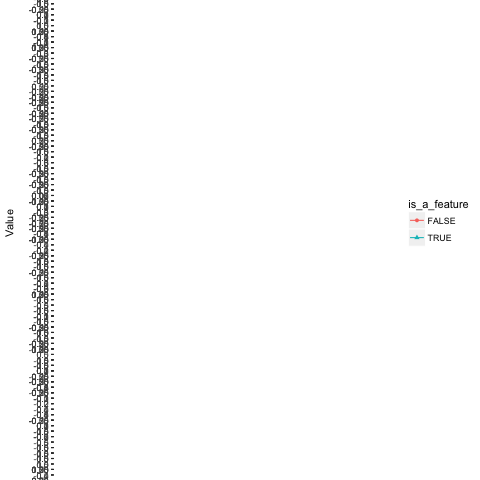

In [20]:
%%R -i feat_names,feat_mat,states,X_test_sequence,FOLDER_OUT

library(ggplot2)
library(scales)
library(dplyr)
library(tidyr)

states_col_names <- paste0('_', 0:(ncol(states)-1))
colnames(states) <- states_col_names
colnames(feat_mat) <- feat_names

to_plot <- cbind(states, feat_mat)
to_plot <- as.data.frame(to_plot)
to_plot[['time']] <- 1:nrow(to_plot)
to_plot <-  gather(to_plot, key='Series', value='Value', -time)
to_plot[['is_a_feature']] <- ! to_plot$Series %in% states_col_names

to_plot <- filter(to_plot, Series %in%states_col_names | is_a_feature)
MAX_TIME <- 150 
to_plot <- filter(to_plot, time <= MAX_TIME)

labels <- X_test_sequence[1:MAX_TIME]
print(labels)

p <- ggplot(to_plot, aes(x=time, y=Value, fill=is_a_feature, color=is_a_feature, shape = is_a_feature)) +
            scale_x_continuous(breaks = sort(unique(to_plot$time)), labels = labels) +
            #scale_y_continuous(limits = c(-1,1), breaks=c(-1,1)) +
            geom_line() +
            geom_point() +
            facet_grid(Series~., scales="free")

ggsave(paste0(FOLDER_OUT, '/activations.pdf'), p, width=40, height=49)

to_plot <- NULL
states <- NULL
feat_mat <- NULL

p

In [21]:
%%R -i feat_names,feat_mat,states,X_test_sequence,FOLDER_OUT

library(ggplot2)
library(scales)
library(dplyr)
library(tidyr)

print(X_test_sequence[1:5])

states_col_names <- paste0('_', 0:(ncol(states)-1))
colnames(states) <- states_col_names
colnames(feat_mat) <- feat_names

to_plot <- cbind(states, feat_mat)
to_plot <- as.data.frame(to_plot)
to_plot[['time']] <- 1:nrow(to_plot)
to_plot[['text']] <- X_test_sequence[1:nrow(to_plot)]

to_plot <-  gather(to_plot, key='Series', value='Value', -time, -text)

MAX_TIME <- 3000 
to_plot <- filter(to_plot, time <= MAX_TIME)

to_plot$Value <- round(to_plot$Value, 2)
write.csv(to_plot, paste0(FOLDER_OUT, '/activations.csv'), row.names = FALSE)

to_plot <- NULL
states <- NULL
feat_mat <- NULL

[1] "_" "k" "t" "h" "r"


# Correlation based attribution

In [22]:
import scores
import inspector as ip

TIMER()
insp = ip.Inspector(nn_config, nn_offsets)
mi_scores, names = insp.inspect(states, feature_frame_x, scores.Correlation())
TIMER()

2017-10-23 15:04
Computing attribution scores
Feture matrix dimensions: (620672, 41)
States dimensions: (620672, 256)
Computing score for feature 0: pos0_10
Layer 0
Timestep 0
Scoring neurons 0 to 255
Computing score for feature 1: pos10_20
Layer 0
Timestep 0
Scoring neurons 0 to 255
Computing score for feature 2: pos20_30
Layer 0
Timestep 0
Scoring neurons 0 to 255
Computing score for feature 3: pos30_40
Layer 0
Timestep 0
Scoring neurons 0 to 255
Computing score for feature 4: pos40_50
Layer 0
Timestep 0
Scoring neurons 0 to 255
Computing score for feature 5: pos50_60
Layer 0
Timestep 0
Scoring neurons 0 to 255
Computing score for feature 6: dep_'('')'_1
Layer 0
Timestep 0
Scoring neurons 0 to 255
Computing score for feature 7: dep_'('')'_2
Layer 0
Timestep 0
Scoring neurons 0 to 255
Computing score for feature 8: dep_'('')'_3
Layer 0
Timestep 0
Scoring neurons 0 to 255
Computing score for feature 9: dep_'('')'_4
Layer 0
Timestep 0
Scoring neurons 0 to 255
Computing score for feature

In [23]:
fname = FOLDER_OUT + '/attributions'
hnames = [repr(n) for n in names]
header = ','.join(hnames)
np.savetxt(fname, mi_scores, delimiter=',', header=header, comments='')

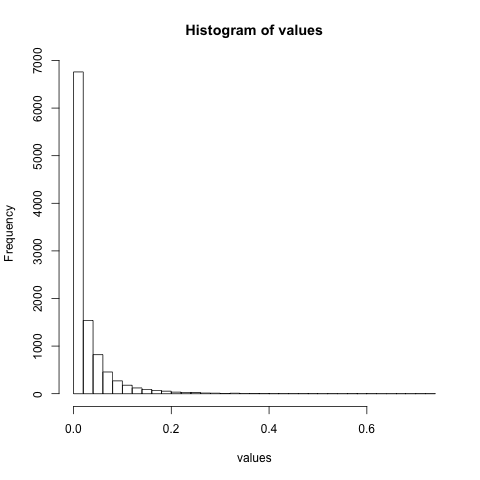

In [24]:
%%R -i mi_scores
values <- c(mi_scores)
hist(values, breaks=30)

In [25]:
feature_neurons = insp.filter_attributions(ip.filter_threshold_abs(.05))
non_feature_neurons = insp.not_attributed()
feature_neurons

{"dep_'('')'_1": [(0, 0, 3),
  (0, 0, 8),
  (0, 0, 19),
  (0, 0, 24),
  (0, 0, 33),
  (0, 0, 35),
  (0, 0, 36),
  (0, 0, 43),
  (0, 0, 46),
  (0, 0, 61),
  (0, 0, 64),
  (0, 0, 86),
  (0, 0, 94),
  (0, 0, 100),
  (0, 0, 103),
  (0, 0, 107),
  (0, 0, 111),
  (0, 0, 112),
  (0, 0, 117),
  (0, 0, 127),
  (0, 0, 128),
  (0, 0, 129),
  (0, 0, 135),
  (0, 0, 140),
  (0, 0, 152),
  (0, 0, 156),
  (0, 0, 161),
  (0, 0, 163),
  (0, 0, 164),
  (0, 0, 168),
  (0, 0, 171),
  (0, 0, 175),
  (0, 0, 179),
  (0, 0, 182),
  (0, 0, 195),
  (0, 0, 202),
  (0, 0, 212),
  (0, 0, 214),
  (0, 0, 215),
  (0, 0, 237),
  (0, 0, 239),
  (0, 0, 245),
  (0, 0, 246),
  (0, 0, 253)],
 "dep_'('')'_2": [(0, 0, 8), (0, 0, 24), (0, 0, 111), (0, 0, 245)],
 "dep_'('')'_3": [],
 "dep_'('')'_4": [],
 "dep_'{''}'_1": [(0, 0, 0),
  (0, 0, 2),
  (0, 0, 8),
  (0, 0, 17),
  (0, 0, 20),
  (0, 0, 24),
  (0, 0, 35),
  (0, 0, 61),
  (0, 0, 71),
  (0, 0, 82),
  (0, 0, 88),
  (0, 0, 103),
  (0, 0, 105),
  (0, 0, 113),
  (0, 0, 114),
 

In [26]:
is_selected = np.zeros_like(mi_scores)
for j, fname in enumerate(names):
    for adress in feature_neurons[fname]:
        i = insp.address_to_column(*adress)
        is_selected[i,j] = 1

/Users/thib/.virtualenvs/keras/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/Users/thib/.virtualenvs/keras/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:  Ignoring unknown parameters: aes

  warnings.warn(x, RRuntimeWarning)


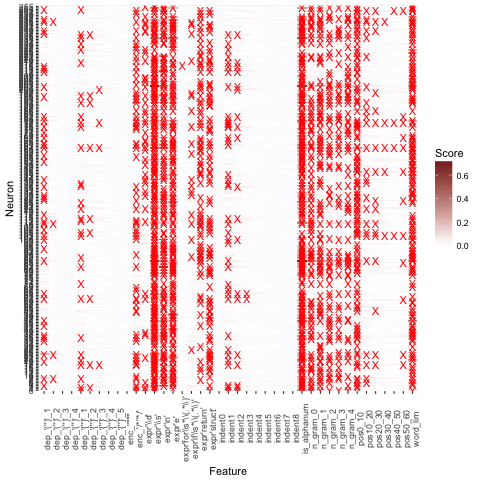

In [27]:
%%R -i mi_scores,names,is_selected,N_STATES,FOLDER_OUT

library(ggplot2)
library(scales) 
library(dplyr)
library(tidyr)

# Gets scores
data <- as.data.frame(mi_scores)
names(data) <- names
data[['Neuron']] <- factor(0:(nrow(data)-1),
                           levels = 0:(nrow(data)-1),
                           labels = as.character(0:(nrow(data)-1)))
data <- gather(data, key='Feature', value='Score', -Neuron)

# Gets neuron selection
sel <- as.data.frame(is_selected)
names(sel) <- names
sel[['Neuron']] <- factor(0:(nrow(sel)-1),
                           levels = 0:(nrow(sel)-1),
                           labels = as.character(0:(nrow(sel)-1)))
sel <- gather(sel, key='Feature', value='selected', -Neuron)
sel$selected <- ifelse(sel$selected == 1, 'X', '')

# joins
to_plot <- inner_join(data,sel, by = c("Neuron", "Feature"))

p <- ggplot(to_plot, aes(x=Feature, y=Neuron, fill=Score, label=selected)) + 
                geom_bin2d(aes='identity') +
                geom_text(color='red') +
                scale_fill_gradient2(midpoint=median(to_plot$Score),
                                    low = muted("blue"), mid = "white",high = muted("red"),
                                    limits=c(0,NA)) +
                theme(axis.text.x = element_text(angle=90))

ggsave(paste0(FOLDER_OUT, '/attribution_map.pdf'), p, width=40, height=40)

mi_scores <- NULL
is_selected <- NULL
data <- NULL
sel <- NULL
to_plot <- NULL

p

# Does the Unit Test

In [ ]:
import scores
TIMER()
out_base = insp.test(states, feature_frame_x, non_feature_neurons, scores.LogRegF1())
TIMER()
out_base

2017-10-23 16:21
Computing scores for pos30_40


In [ ]:
# With the correct neuronss 
out = insp.test(states, feature_frame_x, feature_neurons, scores.LogRegF1())
TIMER()
out

In [ ]:
# Prepares and saves a df
testnames = out.keys()
baseline = [out_base[t] for t in testnames]
candidate = [out[t] for t in testnames]

In [ ]:
%%R -i testnames,baseline,candidate,FOLDER_OUT

toplot <- data.frame(testnames, baseline, candidate)
write.csv(toplot, paste0(FOLDER_OUT,'/test_results'),row.names = FALSE)

dat <- gather(toplot, key='Setting', value='Accuracy', -testnames)

p <- ggplot(dat, aes(x=testnames, y=Accuracy, fill=Setting, color=Setting)) +
        geom_bar(stat='identity', position='dodge') +
        theme(axis.text.x = element_text(angle=90))

print(p)
ggsave(paste0(FOLDER_OUT, '/test_scores.pdf'), p, width=40, height=10)

# Kevinizes

In [ ]:
# from controllers import control
# reload(control)
# import verify
# reload(verify)

# verifier = verify.Verifier(model, feature_neurons, non_feature_neurons)
# v_scores = verifier.run(feature_frame_y, X_test, y_test, BATCH_SIZE, sample_size=SAMPLES_VERIFY)

In [ ]:
# for feat in v_scores:
#     print '---', feat
#     for setup in v_scores[feat]:
#         print '-', setup
#         for y in v_scores[feat][setup]:
#             s = v_scores[feat][setup][y]
#             print y, ':', 'mean:', np.mean(s), '- sd:', np.std(s) 

In [ ]:
# verifier.test_diff()

In [ ]:
# import pandas as pd

# out = None

# for feat in v_scores:
#     print '---', feat
#     for setup in v_scores[feat]:
#         print '-', setup
#         for y in v_scores[feat][setup]:
#             s = np.array(v_scores[feat][setup][y])
#             print y, ':', 'mean:', np.mean(s), '- sd:', np.std(s) 
#             s_y = np.repeat(y, len(s))
#             s_setup = np.repeat(setup, len(s))
#             s_feat = np.repeat(feat, len(s))
#             df = pd.DataFrame({
#                 'acc' : s,
#                 'feat_val': s_y,
#                 'feature': s_feat,
#                 'setup' : s_setup
#             })
#             if out is None:
#                 out = df
#             else:
#                 out = pd.concat([out, df], axis = 0)

# print out
# out.to_csv(FOLDER_OUT+'/kevinizers.csv',index=False)

# Post experiment checks

In [ ]:
feat_names = feature_frame_x.names
feat_mat = feature_frame_x.values

In [ ]:
%%R -i feat_names,X_test_sequence,feat_mat,states

FEATURE <- c('char_i')
NEURON <- c('_156')

MIN_TIME <- 0
MAX_TIME <- 1000

library(ggplot2)
library(scales)
library(dplyr)
library(tidyr)

states_col_names <- paste0('_', 0:(ncol(states)-1))
colnames(states) <- states_col_names
colnames(feat_mat) <- feat_names

to_plot <- cbind(states, feat_mat)
to_plot <- as.data.frame(to_plot)
to_plot[['time']] <- 1:nrow(to_plot)
to_plot <-  gather(to_plot, key='Series', value='Value', -time)
to_plot[['is_a_feature']] <- ! to_plot$Series %in% states_col_names


to_plot <- filter(to_plot, Series %in% states_col_names | is_a_feature)
to_plot <- filter(to_plot, Series %in% c(FEATURE, NEURON))
to_plot <- filter(to_plot, time >= MIN_TIME, time <= MAX_TIME)

labels <- X_test_sequence[MIN_TIME:MAX_TIME]


p <- ggplot(to_plot, aes(x=time, y=Value, fill=is_a_feature, color=is_a_feature, shape = is_a_feature)) +
            scale_x_continuous(breaks = sort(unique(to_plot$time)), labels = labels) +
            #scale_y_continuous(limits = c(-1,1), breaks=c(-1,1)) +
            geom_line() +
            geom_point() +
            facet_grid(Series~., scales="free")
print(p)

fi <- paste0('~/Desktop/focus', paste0(FEATURE, collapse=""), paste0(NEURON, collapse=""), '.pdf')
h <- length(FEATURE) + length(NEURON)
ggsave(fi, p, width=40, height=h)